# Sentinel-2 multiclass classification using Convolutional Neural Network

In [ ]:
!pip install catboost

## Download the EuroSAT dataset


[EuroSAT dataset](https://github.com/phelber/EuroSAT)
![](https://raw.githubusercontent.com/phelber/EuroSAT/master/eurosat_overview_small.jpg)


Download the dataset

In [1]:
import requests

url =  'http://madm.dfki.de/files/sentinel/EuroSAT.zip'
r = requests.get(url, allow_redirects=True)
open('EuroSAT.zip', 'wb').write(r.content)

94280567

Unzip the dataset

In [ ]:
!unzip '/content/EuroSAT.zip'

Rename the folder

In [3]:
!mv '/content/2750' '/content/EuroSAT'

Count images in the dataset

In [4]:
import glob

paths = glob.glob('/content/EuroSAT/*/*')
print('Number of images {}/27000'.format(len(paths)))

Number of images 27000/27000


## Image Data Generator 

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2)
      
train_generator = train_datagen.flow_from_directory(
    '/content/EuroSAT',  
    target_size=(10,10),  
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = train_datagen.flow_from_directory(
    '/content/EuroSAT',  
    target_size=(10,10),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')  

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [2]:
classes = train_generator.class_indices
classes= dict(zip(classes.values(), classes.keys()))  
print(classes)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


Generate some exaples

In [3]:
x,y = next(iter(train_generator))
print('x shape {}'.format(x.shape))
print('y shape {}'.format(y.shape))

x shape (16, 10, 10, 3)
y shape (16, 10)


Plot some examples

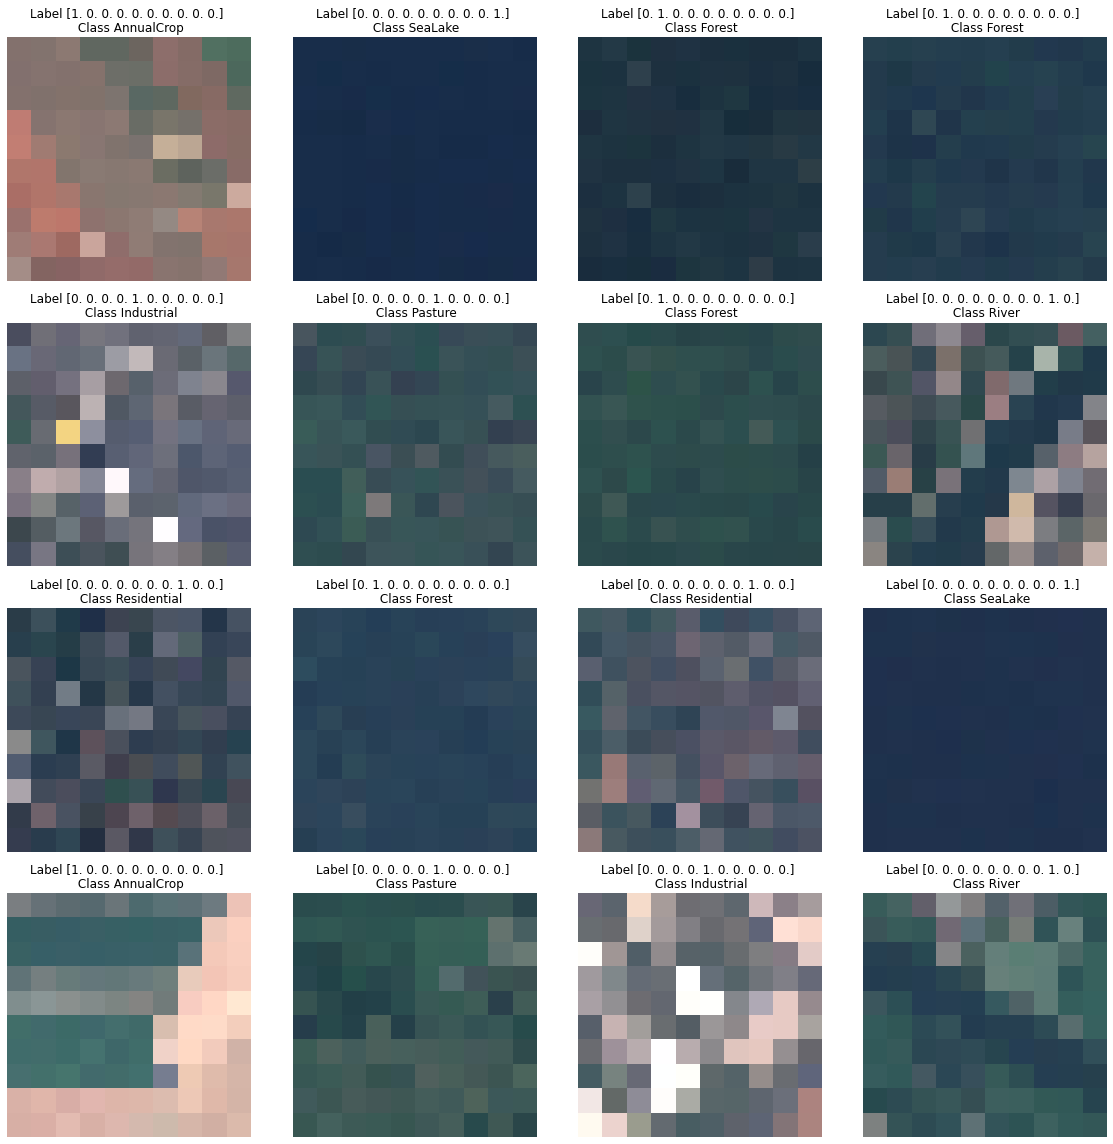

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (16,16))

ct = 0
for i in range(4):
  for j in range(4):
    axes[i,j].imshow(x[ct])
    axes[i,j].set_title('Label {} \n Class {}'.format(y[ct], classes[np.argmax(y[ct])]))
    axes[i,j].axis(False)
    ct += 1

fig.tight_layout()
plt.show()


## Define the Machine Learning model

We will use the CatBoost ([Find out more](https://catboost.ai/en/docs/))

In [19]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=5000,
                          learning_rate=0.02,
                          max_depth=4,
                          loss_function='MultiClass',
                          eval_metric='Accuracy',
                          early_stopping_rounds = 30,
                          verbose = 50)

## Train the CatBoostClassifier

In [11]:
train_generator = train_datagen.flow_from_directory(
    '/content/EuroSAT',  
    target_size=(10, 10),  
    batch_size=train_generator.n,
    class_mode='categorical',
    subset='training')

val_generator = train_datagen.flow_from_directory(
    '/content/EuroSAT',  
    target_size=(10, 10),
    batch_size=val_generator.n,
    class_mode='categorical',
    subset='validation')  


x_train,y_train = next(iter(train_generator))
x_val, y_val = next(iter(train_generator))

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [12]:
from catboost import Pool

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

train_pol = Pool(x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]*x_train.shape[3])),y_train)
val_pol = Pool(x_val.reshape((x_val.shape[0], x_val.shape[1]*x_val.shape[2]*x_val.shape[3])), y_val)

In [20]:
model.fit(train_pol, eval_set=val_pol)

0:	learn: 0.2712037	test: 0.2712037	best: 0.2712037 (0)	total: 366ms	remaining: 12m 12s
1:	learn: 0.2822222	test: 0.2822222	best: 0.2822222 (1)	total: 669ms	remaining: 11m 7s
2:	learn: 0.2931481	test: 0.2931481	best: 0.2931481 (2)	total: 969ms	remaining: 10m 44s
3:	learn: 0.2954167	test: 0.2954167	best: 0.2954167 (3)	total: 1.29s	remaining: 10m 43s
4:	learn: 0.3134722	test: 0.3134722	best: 0.3134722 (4)	total: 1.61s	remaining: 10m 42s
5:	learn: 0.3183333	test: 0.3183333	best: 0.3183333 (5)	total: 1.91s	remaining: 10m 33s
6:	learn: 0.3237037	test: 0.3237037	best: 0.3237037 (6)	total: 2.23s	remaining: 10m 33s
7:	learn: 0.3303241	test: 0.3303241	best: 0.3303241 (7)	total: 2.52s	remaining: 10m 27s
8:	learn: 0.3315278	test: 0.3315278	best: 0.3315278 (8)	total: 2.83s	remaining: 10m 25s
9:	learn: 0.3364352	test: 0.3364352	best: 0.3364352 (9)	total: 3.13s	remaining: 10m 22s
10:	learn: 0.3374537	test: 0.3374537	best: 0.3374537 (10)	total: 3.58s	remaining: 10m 46s
11:	learn: 0.3427778	test: 0.34

## Evaluate Performances

In [23]:
y_pred = model.predict(x_val.reshape((x_val.shape[0], x_val.shape[1]*x_val.shape[2]*x_val.shape[3])))

Compute confusion matrix

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred, normalize='true')

Plot confusion matrix

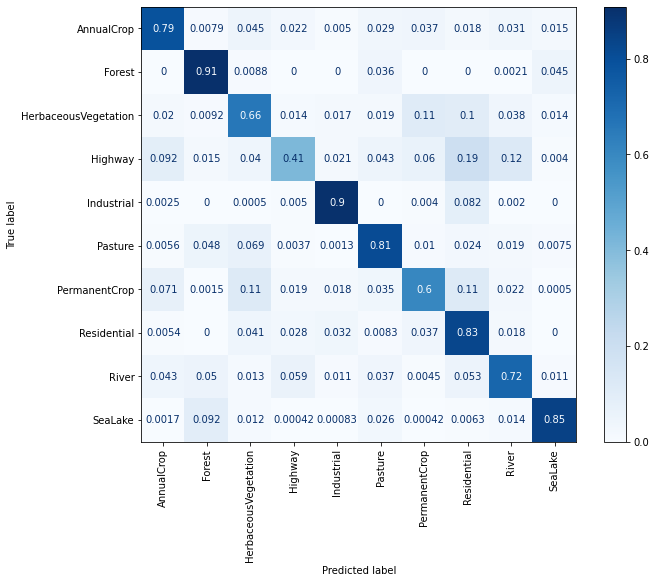

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes.values())
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()

Compute classification report

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred, target_names=classes.values()))

                      precision    recall  f1-score   support

          AnnualCrop       0.79      0.79      0.79      2400
              Forest       0.82      0.91      0.86      2400
HerbaceousVegetation       0.69      0.66      0.68      2400
             Highway       0.72      0.41      0.52      2000
          Industrial       0.89      0.90      0.89      2000
             Pasture       0.72      0.81      0.76      1600
       PermanentCrop       0.67      0.60      0.64      2000
         Residential       0.62      0.83      0.71      2400
               River       0.72      0.72      0.72      2000
             SeaLake       0.90      0.85      0.87      2400

            accuracy                           0.75     21600
           macro avg       0.75      0.75      0.74     21600
        weighted avg       0.76      0.75      0.75     21600

